# Simple geography

This notebook gives examples on how `xroms` can be used to interpret
ROMS results in simple geographical settings. For more advanced geographical
ploting using the cartopy library see the .... notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import xarray as xr
import xroms
%matplotlib inline

### Using the model grid projection

The model grid is an orthogonal map projection. Often quite non-standard, like in our 
case here.

A coastline in lon, lat can be generated from `GSHHS` by the correct `basemap` set-up.
The script `make_coast.py` does the job and save the result as an `.npy`-file.
Using the `ll2xy` method, makes a coast line in the grid projection. It can be useful
to save this as a `.npy` file to speed up generation of grid maps.

A simple way to put the grid on a map, is to add contour lines of longitude and 
latitude.

In [2]:
# Initiate the Dataset
A = xroms.roms_dataset("ocean_avg_0014.nc")


# Find geographic extent
print('Longitude range: {:6.2f}, {:6.2f}'.format(
      A.lon_rho.min().item(), A.lon_rho.max().item()))
print('Latitude range : {:6.2f}, {:6.2f}'.format(
      A.lat_rho.min().item(), A.lat_rho.max().item()))


Longitude range: -20.19,  15.38
Latitude range :  48.00,  65.97


Generate the coast line, both in geographical and grid coordinates.
This processing takes some time, so it it skipped if the coast files
`coast.npy`, `coast_xy.npy` already exists in the present directory.

In [3]:
import os.path

coastfile = 'coast.npy'

if not os.path.isfile('coast.npy'):

    # Generate coast line
    from make_coast import makecoast
    # from lonlat import *

    # Determine geographical extent
    # Use slightly larger extent
    lon0, lon1 = -21, 18  # Longitude range
    lat0, lat1 = 47, 67  # Latitude range

    # Choose GSHHS resolution
    GSHHSres = 'i'   # intermediate resolution

    # Choose a list of GSHHS types
    GSHHStypes = [1]  # land-sea boundary


    # Make the coast line
    makecoast(lon0, lon1, lat0, lat1, GSHHSres, GSHHStypes, coastfile)

    # Test plot
    for p in np.load(coastfile):
        plt.plot(*p)
    

In [4]:
# Make the grid coast file if needed.
if not os.path.isfile('coast_xy.npy'):
    
    # Read and convert to grid coordinates
    xcoast, ycoast = [], []
    xy = []
    for p in np.load(coastfile):
        px, py = xroms.ll2xy(A, *p)
        # Clean up points outside the domain
        px = px[~np.isnan(px)]
        py = py[~np.isnan(py)]
        if len(px) > 0:
            xy.append((px, py))

    # Adjustment for lower left corner to make fill come out right
    px, py = xy[0]
    px = np.concatenate(([0], px))
    py = np.concatenate(([0], py))
    xy[0] = (px, py)
        
    # Save the coastline in grid coordinates
    np.save('coast_xy.npy', xy)

    # Test plot
    for p in xy:
        plt.plot(*p)

The grid coast line, `coast_xy.npy`, can be overlayed on any horizontal field.
Either by `plt.plot` or `plt.fill`. Here land fill is overlayed bottom topography.
Meridians and parallells are added as contour lines
of `lon_rho` and `lat_rho`.

/opt/anaconda/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


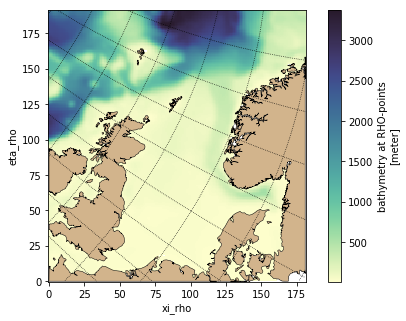

In [5]:
# Read bottom topography
H = A.h.where(A.mask_rho > 0)

# levels for longitude/latitude lines
lons = np.arange(-20, 20, 5)
lats = np.arange(48, 66, 2)

# Coast line
coast_polygons = np.load("coast_xy.npy")

# Make the plot
plt.figure(figsize=(6,5)) 
H.plot(cmap=cmo.deep)
A.lon_rho.plot.contour(levels=lons, colors='black', linewidths=0.7, linestyles=':')
A.lat_rho.plot.contour(levels=lats, colors='black', linewidths=0.7, linestyles=':')
for p in coast_polygons:
    plt.fill(*p, facecolor='Tan', edgecolor='Black', linewidth=0.5)
plt.axis('image');

### Geographical coordinates

Many users prefer a "real" map, where north is up. 
This can be achieved by the flexibility of the `xarray` framework
using alternative coordinates `lon_rho` and `lat_rho` in the
ROMS dataset.

This is demonstrated by plotting a horizontal temperature slice
at 50 meter of the fourth timestamp both in 
grid coordinates and longitude/latitude.

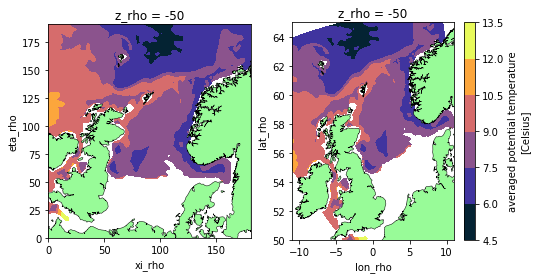

In [6]:
# Select time = 3 and take a slice at 50 meter
depth = 50
temp50 = xroms.zslice(A.temp.isel(time=3), depth)

# Figure with two plots
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

# Grid coordinates
temp50.plot.contourf(ax=axes[0], add_colorbar=False, cmap=cmo.thermal)
xy_polygons = np.load('coast_xy.npy')
for p in xy_polygons:
    axes[0].fill(*p, facecolor='PaleGreen', edgecolor='black', lw=0.5)
axes[0].axis('image')

# Geographical coordinates
temp50.plot.contourf('lon_rho', 'lat_rho', ax=axes[1], cmap=cmo.thermal)
coast_polygons = np.load('coast.npy')
for p in coast_polygons:
    axes[1].fill(*p, facecolor='PaleGreen', edgecolor='black', lw=0.5)
axes[1].axis([-11, 11, 50, 65]);

### Regrid to longitude, latitude grid

An alternative strategy is to regrid to a rectangular grid in longitude/latitude.

Here a subarea covering the Skagerrak is used. The geographical grid has resolution
4′= (1/15)° E–W and 2′ = (1/30)° N–S, both approximately 3.7 km. This is finer than
the model grid which has a resolution 6–7 km in the area.

In [7]:
# Define the geographical grid
lon0, lon1, dlon = 6, 12, 15    # 4 min = 1/15 deg
nlon = (lon1-lon0)*dlon + 1
lon = np.linspace(lon0, lon1, nlon)

lat0, lat1, dlat = 56, 60, 30   # 2 min = 1/30 deg, 
nlat = (lat1-lat0)*dlat + 1
lat = np.linspace(lat0, lat1, nlat)

# Make the 2D grid
lon2, lat2 = np.meshgrid(lon, lat)
# The grid points in the model grid
x2, y2 = xroms.ll2xy(A, lon2, lat2)

# Make DataArrays 
coords = dict(latitude=lat, longitude=lon)
x2 = xr.DataArray(x2, dims=coords.keys(), coords=coords)
y2 = xr.DataArray(y2, dims=coords.keys(), coords=coords)

# The regridded Dataset
B = A.interp(xi_rho=x2, eta_rho=y2)

Plot the regridded bathymetry in plain longitude/latitude.
(Plate Carée projection in cartopy terminology).
The distortion is not too large on such a small area.


Text(11.3,58.6,'Sweden')

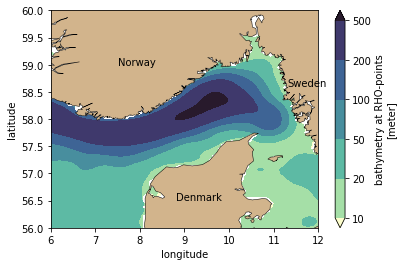

In [8]:
HB = B.h.where(B.mask_rho > 0.5)
levels = [10, 20, 50, 100, 200, 500]
coast_polygons = np.load('coast.npy')

plt.figure()
HB.plot.contourf(levels=levels, cmap=cmo.deep)
for p in coast_polygons:
    plt.fill(*p, facecolor='Tan', edgecolor='Black', lw=0.5)
    
# Add some annotations
plt.text( 7.5, 59,   'Norway')
plt.text( 8.8, 56.5, 'Denmark')
plt.text(11.3, 58.6, 'Sweden')